In [542]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
import nltk
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [543]:
df = pd.read_csv('questions.csv')
print('# of rows:',df.shape[0],'\n# of columns:',df.shape[1])
df.head()

# of rows: 2238 
# of columns: 14


,Question ID,Question Title,Question Slug,Question Text,Topic Tagged text,Difficulty Level,Success Rate,total submissions,total accepted,Likes,Dislikes,Hints,Similar Questions ID,Similar Questions Text
0,1,Two Sum,two-sum,Given an array of integers nums and an integer...,"Array,Hash Table",Easy,48.5,13207990,6403821,31242,988,A really brute force way would be to search fo...,"15,18,167,170,560,653,1083,1798,1830,2116,2133...","3Sum,4Sum,Two Sum II - Input Array Is Sorted,T..."
1,2,Add Two Numbers,add-two-numbers,You are given two non-empty linked lists repre...,"Linked List,Math,Recursion",Medium,38.5,6987977,2690949,17799,3682,NaN,"43,67,371,415,445,1031,1774","Multiply Strings,Add Binary,Sum of Two Integer..."
2,3,Longest Substring Without Repeating Characters,longest-substring-without-repeating-characters,"Given a string s, find the length of the longe...","Hash Table,String,Sliding Window",Medium,33.0,9621884,3175843,22941,1027,NaN,"159,340,1034,1813,2209",Longest Substring with At Most Two Distinct Ch...
3,4,Median of Two Sorted Arrays,median-of-two-sorted-arrays,Given two sorted arrays nums1 and nums2 of siz...,"Array,Binary Search,Divide and Conquer",Hard,34.0,3941694,1340565,15987,1964,NaN,NaN,NaN
4,5,Longest Palindromic Substring,longest-palindromic-substring,"Given a string s, return the longest palindrom...","String,Dynamic Programming",Medium,31.8,5618701,1784028,17097,1005,How can we reuse a previously computed palindr...,"214,266,336,516,647","Shortest Palindrome,Palindrome Permutation,Pal..."


In [544]:
# rename and check columns for NaN
print(df.isna().sum(axis=0))
cols = df.columns.str.extract('(^[Q].+\s*ID|Text|Hints|Slug)').dropna().index
df = df.drop(columns = df.columns[cols])
df.columns = df.columns.str.extract('(\w+$|Topic|Similar)')[0].apply(lambda x: x.lower())
# change rows no related questions from NaN to 0
df = df.drop(index=df.loc[df.topic.isna()].index)
df.similar = df.similar.apply(lambda x: 0 if isinstance(x,float) else x)
# change topics from str to list
df.topic = df.topic.apply(lambda x: x.split(','))
print('\n# of rows:',df.shape[0],'\n# of columns:',df.shape[1])
df.tail()


Question ID                  0
Question Title               0
Question Slug                0
Question Text              480
Topic Tagged text            2
Difficulty Level             0
Success Rate                 0
total submissions            0
total accepted               0
Likes                        0
Dislikes                     0
Hints                     1003
Similar Questions ID       982
Similar Questions Text     982
dtype: int64

# of rows: 2236 
# of columns: 9


,title,topic,level,rate,submissions,accepted,likes,dislikes,similar
2231,Maximum Sum Score of Array,"[Array, Prefix Sum]",Medium,67.0,1031,691,21,6,"560,724,2102"
2232,Users With Two Purchases Within Seven Days,[Database],Medium,47.9,900,431,5,3,1852
2233,The Users That Are Eligible for Discount,[Database],Easy,49.3,603,297,4,2,2336
2235,Add Two Integers,[Math],Easy,93.5,6800,6356,58,256,0
2236,Root Equals Sum of Children,"[Tree, Binary Tree]",Easy,91.4,4698,4294,56,103,0


In [545]:
def searchTopic(tag, lvl=None):
    res = [i for i in df.index if tag in df.loc[i].topic]
    return res

In [546]:
import collections
def getTags(lvl):
    tags = sum(df.loc[lvl].topic.values, [])
    count = collections.Counter(tags)
    return count.most_common(10)

In [547]:
for i in df.level.unique():
    ind = df[df.level == i].rate.nsmallest(10).index
    # ind2 = df[df.level == i].rate.nsmallest(10).index
    diff = getTags(ind)                                       # tags of difficulty level
    # tags of worst acceptance rates 
    print(i)
    print(diff)


Easy
[('Array', 5), ('String', 3), ('Shell', 2), ('Hash Table', 2), ('Math', 2), ('Sorting', 1), ('Counting', 1), ('Number Theory', 1), ('Greedy', 1)]
Medium
[('Array', 6), ('String', 3), ('Math', 3), ('Design', 2), ('Sorting', 2), ('Greedy', 2), ('Hash Table', 2), ('Bit Manipulation', 1), ('Simulation', 1), ('Sliding Window', 1)]
Hard
[('String', 6), ('Math', 3), ('Array', 3), ('Greedy', 2), ('Two Pointers', 2), ('Binary Search', 2), ('Dynamic Programming', 2), ('Bit Manipulation', 2), ('Heap (Priority Queue)', 1), ('Design', 1)]


In [548]:
# change diff to numeric
labels = dict(zip(df.level.unique(), range(df.level.nunique())))
df.level = df.level.apply(lambda x: labels[x])
df.similar = df.similar.apply(lambda x: 1 if isinstance(x, int) else len(x.split(',')))
df.head()

,title,topic,level,rate,submissions,accepted,likes,dislikes,similar
0,Two Sum,"[Array, Hash Table]",0,48.5,13207990,6403821,31242,988,12
1,Add Two Numbers,"[Linked List, Math, Recursion]",1,38.5,6987977,2690949,17799,3682,7
2,Longest Substring Without Repeating Characters,"[Hash Table, String, Sliding Window]",1,33.0,9621884,3175843,22941,1027,5
3,Median of Two Sorted Arrays,"[Array, Binary Search, Divide and Conquer]",2,34.0,3941694,1340565,15987,1964,1
4,Longest Palindromic Substring,"[String, Dynamic Programming]",1,31.8,5618701,1784028,17097,1005,5


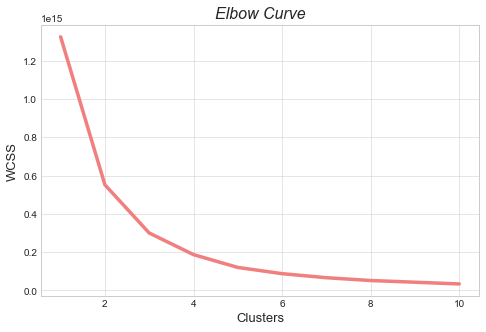

In [549]:
X = df.drop(columns=['title','topic'])
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=30, n_init=10,random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
fig = plt.figure(figsize=(7,5))
fig.patch.set_facecolor('white')
plt.plot(np.arange(1,11),wcss, color='lightcoral', lw=3.5)
plt.title('Elbow Curve',fontsize=16, fontstyle='italic')
plt.xlabel('Clusters', fontsize=13)
plt.ylabel('WCSS', fontsize=13)
plt.show()   # sharpest inflection at (3) clusters

In [550]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cf = pd.DataFrame({'row':X.index.values,'cluster':y_kmeans})

In [551]:
print('Mean Acceptance Rates')
for i in range(cf.cluster.nunique()):
    idx = cf[cf.cluster == i].row
    res = np.round(df.loc[idx].rate.mean(),2)
    print('Cluster ' + str(i+1) +':',res)

Mean Acceptance Rates
Cluster 1: 55.13
Cluster 2: 49.4
Cluster 3: 35.16


In [558]:
clusts = pd.DataFrame(columns=['Cluster 1','Cluster 2', 'Cluster 3'])
for i in range(cf.cluster.nunique()):
    ind = cf[cf.cluster == i].row
    clusts['Cluster ' + str(i+1)] = [i[0] for i in getTags(ind)]
    print('Cluster #' + str(i+1))
    print('Average Completion:', f'{df.loc[ind].rate.mean():.2f}%')
    print('Submissions:', int(df.loc[ind].submissions.mean()))
    print('Acceptances:', int(df.loc[ind].accepted.mean()), '\n')
clusts


Cluster #1
Average Completion: 55.13%
Submissions: 150729
Acceptances: 79634 

Cluster #2
Average Completion: 49.40%
Submissions: 1855639
Acceptances: 895115 

Cluster #3
Average Completion: 35.16%
Submissions: 7210189
Acceptances: 2594572 



,Cluster 1,Cluster 2,Cluster 3
0,Array,Array,String
1,String,String,Array
2,Hash Table,Hash Table,Hash Table
3,Dynamic Programming,Two Pointers,Math
4,Math,Depth-First Search,Dynamic Programming
5,Greedy,Dynamic Programming,Linked List
6,Sorting,Tree,Recursion
7,Depth-First Search,Binary Tree,Sliding Window
8,Database,Math,Two Pointers
9,Breadth-First Search,Linked List,Sorting


In [557]:
taglist = sum(df.topic.values, [])
counts = collections.Counter(taglist)
for i in set(taglist):
    temp = 


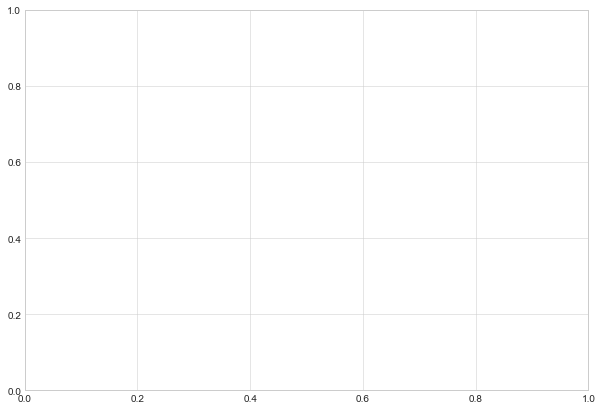

In [554]:
categories = ['Submissions', 'Accepted']

fig, ax = plt.subplots(figsize=(9,7))

plt.show()